# Simulation of Other Methods

## 1. Graph System Identification (GSI) from paper [Graph Learning From Filtered Signals: Graph System and Diffusion Kernel Identification](https://arxiv.org/pdf/1803.02553.pdf)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import scipy.io
import collections

import os
import sys
sys.path.append('/Users/apple/Desktop/graph_learning/FilterLearning/src')

from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error

import generators as gen
import optimize as opt
import helpers as hel
import pickle as pkl
from NNet import NNet
from networkx.generators.community import stochastic_block_model


%load_ext autoreload
%autoreload 2

In [2]:
os.getcwd()

'/Users/apple/Desktop/graph_learning/FilterLearning/examples'

In [3]:
def gen_samples(L, n_samples=500):
    """Reproducibly generates 500 samples from L."""
    if type(L) is not torch.Tensor:
        L = torch.Tensor(L)
    
    samples = gen.gen_white_noise(n_samples, L.shape[0], random_state=None)
    return samples

# generate graphs
def generate_L_sbm(nnodes=10, p_in=.8, p_out=.1, seed=42, n_blocks=2):
    """generates Laplacian of stochastic block model with 2 clusters, with nnodes."""
    if n_blocks==2:
        G = stochastic_block_model([nnodes//2,nnodes//2],[[p_in,p_out],[p_out,p_in]], seed=seed)
        A = nx.adjacency_matrix(G).todense()
        L = nx.laplacian_matrix(G).todense()  
    else:
        prob_matrix = np.eye(n_blocks)*(p_in-p_out) + p_out
        G = stochastic_block_model([nnodes//n_blocks]*n_blocks, prob_matrix, seed=seed)  
        A = nx.adjacency_matrix(G).todense()          
        L = nx.laplacian_matrix(G).todense()
    samples = gen_samples(L,n_samples=500)
    return  L, A

def create_multiple_graphs(n_graphs=20, **kwargs):
    return [generate_L_sbm(seed=i, **kwargs) for i in range(n_graphs)]

def to_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pkl.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, 'rb') as f:
        return pkl.load(f)

In [4]:
res_30 = create_multiple_graphs(20, nnodes=45, p_in=.3, p_out=.1, n_blocks=3)
As_30 = [i[1] for i in res_30]
Ls_30 = [i[0] for i in res_30]
to_pickle(Ls_30, 'GSI/data/Ls_30.pkl')
to_pickle(As_30, 'GSI/data/As_30.pkl')
scipy.io.savemat('GSI/mat_files/As_30.mat', mdict={'As': As_30})
scipy.io.savemat('GSI/mat_files/Ls_30.mat', mdict={'Ls': Ls_30})


res_50 = create_multiple_graphs(20, nnodes=45, p_in=.5, p_out=.1, n_blocks=3)
As_50 = [i[1] for i in res_50]
Ls_50 = [i[0] for i in res_50]
to_pickle(Ls_50, 'GSI/data/Ls_50.pkl')
to_pickle(As_50, 'GSI/data/As_50.pkl')
scipy.io.savemat('GSI/mat_files/Ls_50.mat', mdict={'Ls': Ls_50})
scipy.io.savemat('GSI/mat_files/As_50.mat', mdict={'As': As_50})


res_70 = create_multiple_graphs(20, nnodes=45, p_in=.7, p_out=.1, n_blocks=3)
As_70 = [i[1] for i in res_70]
Ls_70 = [i[0] for i in res_70]
to_pickle(Ls_70, 'GSI/data/Ls_70.pkl')
to_pickle(As_70, 'GSI/data/As_70.pkl')
scipy.io.savemat('GSI/mat_files/Ls_70.mat', mdict={'Ls': Ls_70})
scipy.io.savemat('GSI/mat_files/As_70.mat', mdict={'As': As_70})



In [5]:
def load_saved_data():
    all_list = [Ls_30,Ls_50,Ls_70,As_30,As_50,As_70]
    all_list_str = ['Ls_30','Ls_50','Ls_70','As_30','As_50','As_70']
    for l,l_str in zip(all_list,all_list_str):
        l = from_pickel(l_str)


In [6]:
def sample_kernel(L, ker, n_samples=500):
    """Reproducibly generates 500 samples from L using kernel ker, then 
    imputes a graph using the imputer. Imputer is a function that
    takes samples and returns an adjacency matrix."""
    
    samples = gen.gen_and_filter(L, n_samples, ker=ker, seed=42)
    return samples.squeeze().tolist() 


def generate_samples(Ls, ker, verbose=True):
    """For every L in Ls, generates samples with ker and imputes the graph
    using the imputer method. Imputer is a function that
    takes samples and returns an adjacency matrix."""
    out = []
    for i, L in enumerate(Ls):
        if verbose:
            print('\rGenerating sample {}'.format(i+1), end=' ')
        out.append(sample_kernel(L, ker))
    return out

def f1_scores(Ls, imps):
    """Calculates f1 scores between lists"""
    return [f1_score(np.asarray(L<0).flatten(),(imp<0).flatten()) for L, imp in zip(Ls, imps)]

def accuracy_scores(Ls, imps):
    """Calculates accuracy scores for lists"""
    return [accuracy_score(np.asarray(L<0).flatten(),(imp<0).flatten(),normalize=True) for L, imp in zip(Ls, imps)]

def mae_scores(Ls, imps):
    """Calculates mean absolute error for lists"""
    return [mean_absolute_error(np.asarray(L).flatten(),(imp).flatten()) for L, imp in zip(Ls, imps)]

def process_samples(savefile_prefix):
    kerlist = [gen.kernel_heat, gen.kernel_normal, 
               lambda x: gen.kernel_highpass(x, par=.5)]
    kernames = ['heat', 'norm', 'high']
    
    Lslist = [Ls_30, Ls_50, Ls_70]
    Lsnames = ['30', '50', '70']
    
    for ker, kername in zip(kerlist, kernames):
        print('Kernel:', kername)
        
        for Ls, Lsname in zip(Lslist, Lsnames):
            print('Ls:', Lsname)
            
            samples = generate_samples(Ls, ker)

            savefile_suffix = '_' + Lsname + '_' + kername + '.pkl'
            to_pickle(samples, savefile_prefix + Lsname + '_' + kername + '.pkl')
            scipy.io.savemat('GSI/mat_files/samples_'+ Lsname + '_' + kername + '.mat', mdict={'samples': samples})

        
        

In [7]:
#generate_samples('GSI/data/samples_')

Use data saved in 'GSI/mat_files' and run algorithm in MATLAB. Then run the rest of this notebook. 

In [8]:
def plot_GSI(data,title):
    fig, axs = plt.subplots(4,5)
    fig.suptitle(title)
    k = 0
    for i in range(4):
        for j in range(5):
            axs[i, j].imshow(data[k])
            k+=1

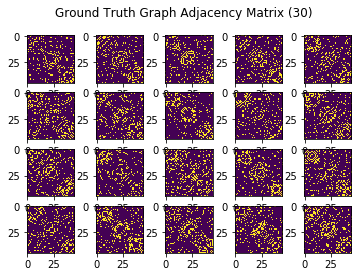

In [9]:
plot_GSI(As_30,'Ground Truth Graph Adjacency Matrix (30)')

In [10]:
def load_mat_files():
    all_mat_dict = {}
    type_list = ['Ls','As']
    algs = ['GSI', 'CGL', 'GGL','DDGL']
    Ls_list = ['30','50','70']
    ker_list = ['heat','norm','high']
    for t in type_list:
        for L in Ls_list:
            for ker in ker_list:
                for alg in algs:
                    loaded_dict = scipy.io.loadmat('GSI/mat_files/' + t + '_' + L +'_' + ker + 'kernel' + '_' + alg + '_res.mat')
                    loaded = loaded_dict[t + '_'+ alg + '_est']   
                    all_mat_dict[t + '_' + L +'_' + ker + 'kernel' + '_' + alg] = loaded
    return all_mat_dict

In [11]:
all_mat_dict = load_mat_files()
(all_mat_dict).keys()

dict_keys(['Ls_30_heatkernel_GSI', 'Ls_30_heatkernel_CGL', 'Ls_30_heatkernel_GGL', 'Ls_30_heatkernel_DDGL', 'Ls_30_normkernel_GSI', 'Ls_30_normkernel_CGL', 'Ls_30_normkernel_GGL', 'Ls_30_normkernel_DDGL', 'Ls_30_highkernel_GSI', 'Ls_30_highkernel_CGL', 'Ls_30_highkernel_GGL', 'Ls_30_highkernel_DDGL', 'Ls_50_heatkernel_GSI', 'Ls_50_heatkernel_CGL', 'Ls_50_heatkernel_GGL', 'Ls_50_heatkernel_DDGL', 'Ls_50_normkernel_GSI', 'Ls_50_normkernel_CGL', 'Ls_50_normkernel_GGL', 'Ls_50_normkernel_DDGL', 'Ls_50_highkernel_GSI', 'Ls_50_highkernel_CGL', 'Ls_50_highkernel_GGL', 'Ls_50_highkernel_DDGL', 'Ls_70_heatkernel_GSI', 'Ls_70_heatkernel_CGL', 'Ls_70_heatkernel_GGL', 'Ls_70_heatkernel_DDGL', 'Ls_70_normkernel_GSI', 'Ls_70_normkernel_CGL', 'Ls_70_normkernel_GGL', 'Ls_70_normkernel_DDGL', 'Ls_70_highkernel_GSI', 'Ls_70_highkernel_CGL', 'Ls_70_highkernel_GGL', 'Ls_70_highkernel_DDGL', 'As_30_heatkernel_GSI', 'As_30_heatkernel_CGL', 'As_30_heatkernel_GGL', 'As_30_heatkernel_DDGL', 'As_30_normkernel_G

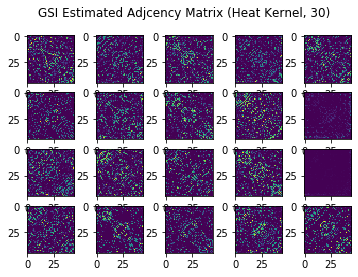

In [12]:
plot_GSI(all_mat_dict['As_30_heatkernel_GSI'], 'GSI Estimated Adjcency Matrix (Heat Kernel, 30)')

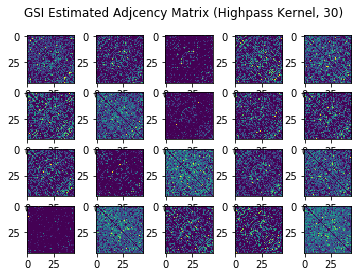

In [13]:
plot_GSI(all_mat_dict['As_30_highkernel_GSI'],'GSI Estimated Adjcency Matrix (Highpass Kernel, 30)')

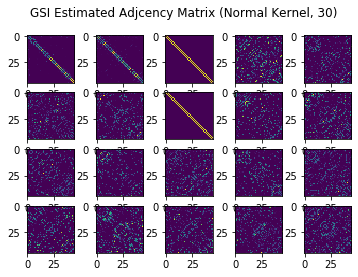

In [14]:
plot_GSI(all_mat_dict['As_30_normkernel_GSI'],'GSI Estimated Adjcency Matrix (Normal Kernel, 30)')

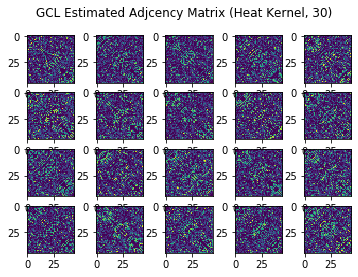

In [15]:
plot_GSI(all_mat_dict['As_30_heatkernel_CGL'],'GCL Estimated Adjcency Matrix (Heat Kernel, 30)')

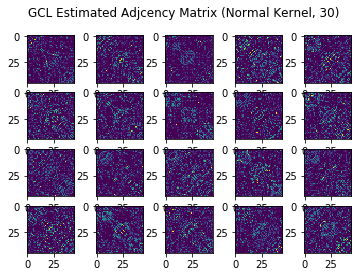

In [16]:
plot_GSI(all_mat_dict['As_30_normkernel_CGL'],'GCL Estimated Adjcency Matrix (Normal Kernel, 30)')

In [17]:
def calculate_scores(data_dict,Lslist):
    kernames = ['heat', 'norm', 'high']
    algs = ['GSI','CGL','GGL','DDGL']
    Lsnames = ['30', '50', '70']
    f1_dict = {} 
    acc_dict = {}  
    mae_dict = {}
    for alg in algs: 
        for Ls, Lsname in zip(Lslist, Lsnames):
            print('Ls:', Lsname)
            for ker in kernames:
                print('Kernel:', ker)
                f1_dict[Lsname + '_' + ker + '_' + alg]= f1_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
                acc_dict[Lsname + '_' + ker + '_' + alg] = accuracy_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
                mae_dict[Lsname + '_' + ker + '_' + alg] = mae_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
    return f1_dict, acc_dict, mae_dict

In [18]:
f1_dict, acc_dict, mae_dict = calculate_scores(all_mat_dict,[Ls_30, Ls_50, Ls_70])

Ls: 30
Kernel: heat


UnboundLocalError: local variable 'i' referenced before assignment

Calculate the average f1-score,  avg accuracy score, and MAE values for each type of kernel:

In [ ]:
def score_avg(data):
    Lslist = ['30', '50', '70']
    kernames = ['heat', 'norm', 'high']
    algs = ['GSI','CGL','GGL','DDGL']
    Lsnames = ['30', '50', '70']
    avg=collections.defaultdict(dict)
    for kername in kernames:
        for alg in algs:
            avg[kername][alg] = {}
            for L in  Lslist:
                avg[kername][alg][L]= np.mean(data[L + '_' + kername + '_' + alg]) # for L in Lslist])
    return avg

In [ ]:
f1_avg = score_avg(f1_dict)
f1_avg

In [ ]:
acc_avg = score_avg(acc_dict)
acc_avg

In [ ]:
mae_avg = score_avg(acc_dict)
mae_avg

## Plot our results to compare

In [ ]:
def plot_results(data,y_title):
    algs = ['GSI','CGL','DDGL','GGL']
    kernames = ['heat', 'norm', 'high']
    Lsnames = ['30', '50', '70']
    fig, axs = plt.subplots(3)
    # fig.xlabel("Number of vertices")
    # fig.ylabel(y_title) 
    for i,kernel in enumerate(kernames):
        for alg in algs:
            axs[i].plot([30,50,70],list(data[kernel][alg].values()),'-o',label= alg)
            plt.show
        plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
            
    for ax in axs.flat:
        ax.set(xlabel='Number of vertices', ylabel=y_title)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()


In [ ]:
plot_results(f1_avg,"Average F1-score")

In [ ]:
plot_results(acc_avg,"Average Acc. Score")

In [ ]:
plot_results(mae_avg,"Average MAE")